# Reddit Classification 

## Notebook 3 of 5 - (Vectorisation + Modelling) Part 1 of 2

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import re
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set_theme()

In [3]:
anxiety_depression = pd.read_csv('datasets/anxiety_depression.csv')

In [4]:
anxiety_depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29907 entries, 0 to 29906
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   is_anxiety         29907 non-null  int64 
 1   title_text         29907 non-null  object
 2   date_time          29907 non-null  object
 3   title_text_re      29907 non-null  object
 4   status_length      29907 non-null  int64 
 5   status_word_count  29907 non-null  int64 
 6   day                29907 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.6+ MB


# Pipeline (Vectorisation + Modelling)

Two Vectorizers are selected and this will be used together with the estimators in pipeline  
Pipeline 1 = CountVectorizer() + Estimators (LogReg, kNN, MultinomialNB)  
Pipeline 2 = TfidfVectorizer() + Estimators (LogReg, kNN, MultinomialNB)  
Pipeline 3 = TfidfVectorizer() + RandomForest (In Notebook 4)  
Pipeline 4 = TfidfVectorizer() + Pycaret Model (In Notebook 4)

In [5]:
# Recall that a new column was created after doing Regex, thus new 'X'
X2 = anxiety_depression['title_text_re']
y = anxiety_depression['is_anxiety']

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X2,y,stratify=y,random_state=42)

In [7]:
# The dataset is balanced 
y_test.value_counts(normalize=True)

1    0.505283
0    0.494717
Name: is_anxiety, dtype: float64

In [8]:
# Instantiate the Vectorizers
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [9]:
# Instantiate the Estimators
logreg = LogisticRegression()
knn = KNeighborsClassifier()
nb = MultinomialNB()

## Pipeline 1

### CountVectorizer + Estimator Models (Logistic Regression, KNeighbors, MultinomialNB)

In [9]:
# Using pipeline which includes the vectorizer and estimators
main_pipe1 = Pipeline(
    steps=[('vec',cv),
           ('est','')
          ])

In [10]:
# lemmtisation 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [11]:
# Stemming
class StemmTokenizer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, articles):
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

In [12]:
# Using custom stopwords from notebook 2
stop_words = frozenset(['removed','deleted','anxiety','anxious','depression','depressed'])
custom_stop_words = stop_words.union(CountVectorizer(stop_words = 'english').get_stop_words())

In [13]:
# Pipeline parameters 
# CV parameters
main_pipe_params1 = {
    'vec__max_features':[3000,4000,5000], # This is to limit the features and to prevent overly common words to be included in the model.
    'vec__stop_words':[custom_stop_words], # A custom_stop_words list is created as per above and described in notebook 2.
    'vec__tokenizer':[None,LemmaTokenizer(),StemmTokenizer()], # All three tokenizer were input and gridsearch to identify the best.
    'vec__min_df': [2, 3], # The value of min_df was decided to have some a minimum count in documents
    'vec__max_df': [.9, .95], # The value of max_df was to exclude the top few % of total counts to prevent common words.
    'vec__ngram_range': [(1,1), (1,2)] # As observed in previous notebook, there is no major keywords in post. Thus, unigram and unigram-bigram combination was chosen.
}
# Logreg parameters
param0 = {
    'est':[logreg],
    'est__max_iter': [700], # This value was input to overcome the non-convergence issue
    'est__C':[0.1,1] # The strength of regularisation
}
param0.update(main_pipe_params1)

# kNN parameters
param1 = {
    'est':[knn],
    'est__n_neighbors':[5,15,25] # To input the strength of fitting
}
param1.update(main_pipe_params1)

# MultinomialNB parameters
param2 = {
    'est':[nb],
    'est__alpha':[0.5,1] # The strength of regularisation
}
param2.update(main_pipe_params1)
    
multipipe_params1 = [param0, param1, param2]

In [14]:
# Instantiating gridsearch with preset parameters with cross-validation = 5)
gs1 = GridSearchCV(main_pipe1,
                  param_grid = multipipe_params1,
                  verbose = 10,
                  scoring = 'accuracy',
                  cv=5,
                  n_jobs=-1)

In [15]:
%%time
# Fitting the model
gs1_fit = gs1.fit(X_train, y_train)  

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


C:\Users\calerlime\.conda\envs\dsi-sg\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anxieti', 'anxiou', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'delet', 'depress', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'remov', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wh

CPU times: total: 3min 28s
Wall time: 4h 52min 9s


In [16]:
# Checking the model and parameters that were 
pd.DataFrame(gs1.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est,param_est__C,param_est__max_iter,param_vec__max_df,param_vec__max_features,param_vec__min_df,...,param_est__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,153.009095,1.890273,37.219035,0.675563,"LogisticRegression(C=0.1, max_iter=700)",0.1,700,0.9,5000,2,...,NaN,"{'est': LogisticRegression(C=0.1, max_iter=700...",0.895230,0.891440,0.905930,0.905261,0.900357,0.899643,0.005628,1
65,162.149465,1.413787,38.192602,0.867710,"LogisticRegression(C=0.1, max_iter=700)",0.1,700,0.95,5000,2,...,NaN,"{'est': LogisticRegression(C=0.1, max_iter=700...",0.895230,0.891440,0.905930,0.905261,0.900357,0.899643,0.005628,1
35,156.860510,1.677988,39.252573,1.333935,"LogisticRegression(C=0.1, max_iter=700)",0.1,700,0.9,5000,3,...,NaN,"{'est': LogisticRegression(C=0.1, max_iter=700...",0.895230,0.891217,0.905930,0.904815,0.899911,0.899420,0.005596,3
71,155.728241,1.428291,37.332918,0.825619,"LogisticRegression(C=0.1, max_iter=700)",0.1,700,0.95,5000,3,...,NaN,"{'est': LogisticRegression(C=0.1, max_iter=700...",0.895230,0.891217,0.905930,0.904815,0.899911,0.899420,0.005596,3
68,151.629824,3.386820,36.468202,0.724344,"LogisticRegression(C=0.1, max_iter=700)",0.1,700,0.95,5000,3,...,NaN,"{'est': LogisticRegression(C=0.1, max_iter=700...",0.898796,0.891440,0.903032,0.902363,0.898796,0.898885,0.004117,5


In [17]:
# Best parameters from pipeline 1
gs1.best_params_

{'est': LogisticRegression(C=0.1, max_iter=700),
 'est__C': 0.1,
 'est__max_iter': 700,
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'anxiety',
            'anxious',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
        

In [18]:
# Accuracy score of train on pipeline 1
gs1.score(X_train, y_train)

0.9394560855996433

In [19]:
# Accuracy score of test on pipeline 1
gs1.score(X_test, y_test)

0.8999598769559984

In [20]:
# Get the predictions from X_test
predictions1 = gs1.predict(X_test)

In [21]:
# Look into the confusion matrix.
confusion_matrix(y_test, predictions1)

array([[3424,  275],
       [ 473, 3305]], dtype=int64)

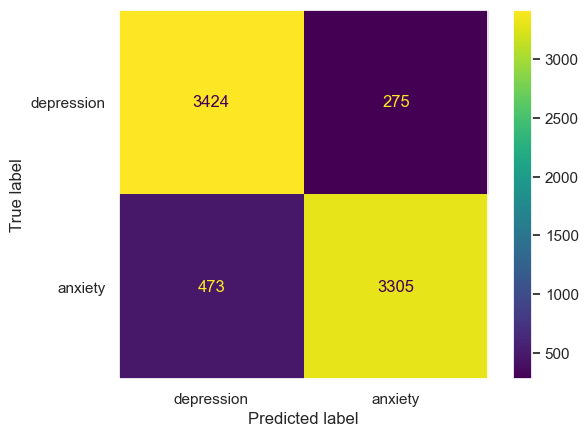

In [22]:
# Look into the confusion matrix diagram
cm = confusion_matrix(y_test, predictions1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['depression', 'anxiety'])
disp.plot()
plt.grid(False)

- The top 5 results from pipeline 1 used the logistic regression model.
- The train score is at 93.9% and the test score at 90.0% which the train and test score is much closer than the base model and test score higher than the base model. 
- The top 5 models also shows that the parameter max_df at 0.90 and 0.95 do perform well and min_df at 2 or 3.
- Thus, pipeline 1 is a better model than base model.

## Pipeline 2

### TFIDFVectorizer + Estimator Models (Logistic Regression, KNeighbors, MultinomialNB)

In [13]:
main_pipe2 = Pipeline(
    steps=[('vec',tfidf),
           ('est','')
          ])

In [14]:
main_pipe_params2 = {
    'vec__max_features':[3000,4000,5000], # This is to limit the features and to prevent overly common words to be included in the model.
    'vec__stop_words':[custom_stop_words], # A custom_stop_words list is created as per above and described in notebook 2.
    'vec__tokenizer':[None,LemmaTokenizer(),StemmTokenizer()], # All three tokenizer were input and gridsearch to identify the best.
    'vec__min_df': [2, 3],    # The value of min_df was decided to have some a minimum count in documents
    'vec__max_df': [.9, .95], # The value of max_df was to exclude the top few % of total counts to prevent common words.
    'vec__ngram_range': [(1,1), (1,2)] # As observed in previous notebook, there is no major keywords in post. Thus, unigram and unigram-bigram combination was chosen.
}

param3 = {
    'est':[logreg],
    'est__max_iter': [700], # This value was input to overcome the non-convergence issue
    'est__C':[0.1,1]  # The strength of regularisation
}
param3.update(main_pipe_params2)

param4 = {
    'est':[knn],
    'est__n_neighbors':[5,15,25] # To input the strength of fitting
}
param4.update(main_pipe_params2)

param5 = {
    'est':[nb],
    'est__alpha':[0.5,1] # The strength of regularisation
} 
param5.update(main_pipe_params2)
    
multipipe_params2 = [param3, param4, param5]

In [15]:
# Instantiating gridsearch with preset parameters with cross-validation = 5)
gs2 = GridSearchCV(main_pipe2, 
                  param_grid = multipipe_params2,
                  verbose = 10,
                  scoring = 'accuracy',
                  cv=5,
                  n_jobs=-1)

In [16]:
%%time
# Fitting the model
gs2_fit = gs2.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


C:\Users\calerlime\.conda\envs\dsi-sg\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anxieti', 'anxiou', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'delet', 'depress', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'remov', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wh

CPU times: total: 3min 38s
Wall time: 3h 56min 50s


In [17]:
# Look into the top 5 scores of pipeline 2
pd.DataFrame(gs2.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est,param_est__C,param_est__max_iter,param_vec__max_df,param_vec__max_features,param_vec__min_df,...,param_est__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
110,103.491517,1.159566,27.011367,0.928185,"LogisticRegression(C=1, max_iter=700)",1,700,0.95,3000,2,...,NaN,"{'est': LogisticRegression(C=1, max_iter=700),...",0.902586,0.903700,0.908159,0.905707,0.905930,0.905216,0.001930,1
74,104.533197,1.582804,25.763727,0.825657,"LogisticRegression(C=1, max_iter=700)",1,700,0.9,3000,2,...,NaN,"{'est': LogisticRegression(C=1, max_iter=700),...",0.902586,0.903700,0.908159,0.905707,0.905930,0.905216,0.001930,1
80,103.164054,0.528614,25.811443,0.412395,"LogisticRegression(C=1, max_iter=700)",1,700,0.9,3000,3,...,NaN,"{'est': LogisticRegression(C=1, max_iter=700),...",0.902809,0.903477,0.907936,0.905484,0.905930,0.905127,0.001831,3
116,106.337990,1.587930,26.250647,0.915040,"LogisticRegression(C=1, max_iter=700)",1,700,0.95,3000,3,...,NaN,"{'est': LogisticRegression(C=1, max_iter=700),...",0.902809,0.903477,0.907936,0.905484,0.905930,0.905127,0.001831,3
92,101.634915,0.598947,25.860834,0.946728,"LogisticRegression(C=1, max_iter=700)",1,700,0.9,4000,3,...,NaN,"{'est': LogisticRegression(C=1, max_iter=700),...",0.901471,0.903700,0.907267,0.904815,0.907044,0.904860,0.002163,5


In [18]:
# Best parameters from pipeline 2
gs2.best_params_

{'est': LogisticRegression(C=1, max_iter=700),
 'est__C': 1,
 'est__max_iter': 700,
 'vec__max_df': 0.9,
 'vec__max_features': 3000,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'anxiety',
            'anxious',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            

In [19]:
# Accuracy score of train on pipeline 2
gs2.score(X_train, y_train)

0.9236290682122158

In [20]:
# Accuracy score of test on pipeline 2
gs2.score(X_test, y_test)

0.9059783335562391

In [21]:
# Get the predictions from X_test
predictions2 = gs2.predict(X_test)

In [22]:
# Get the confusion matrix from the predicted labels and compared to true labels
confusion_matrix(y_test, predictions2)

array([[3420,  279],
       [ 424, 3354]], dtype=int64)

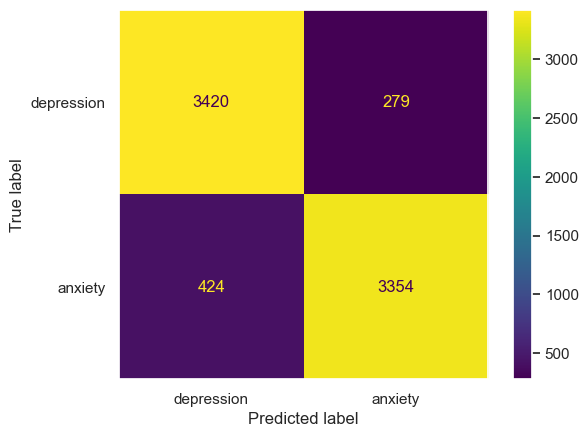

In [23]:
# Look into the confusion matrix.
cm = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['depression', 'anxiety'])
disp.plot()
plt.grid(False)

- The top 5 results from pipeline 2 used the logistic regression model.
- The train score is at 92.4% and the test score at 90.6% which the train and test score is much closer than the base model and test score higher than the base model. 
- The top 5 models also shows that the parameter max_df at 0.90 and 0.95 do perform well and min_df at 2 or 3.
- Pipeline 2 is a better model than pipeline 1 and base model.

# Evaulation of Pipeline 1 and Pipeline 2

|Pipeline|Vectorizer|Estimator|Parameters for Vectorizer|Parameters for Estimator|Train|Test
|----|----|----|----|----|----|----|
|Base|CountVectorizer|Logsitic Regression|-|max_iter = 700|0.971|0.886|
|1|CountVectorizer|Logistic Regression|max_df = 0.9, max_features = 5000, min_df = 2, ngram_range: (1,2), stop_words = custom_stop_words, Tokenizer = StemmTokenizer|c=0.1, max_iter = 700|0.930|0.900|
|2|TFIDF|Logistic Regression|max_df = 0.9, max_features = 3000, min_df = 2, ngram_range: (1,1), stop_words = custom_stop_words, Tokenizer = StemmTokenizer|c=1, max_iter = 700|0.924|0.906|

The accuracy of pipeline 2 is higher than pipeline 1.
The difference between the train and test scores are also closer in pipeline 2 than pipeline 1. 

A smaller regularization (c=1) was chosen compared to (c=0.1) which shows that pipeline 2 has a lesser overfit issue. This is confirmed by observing the difference between train value (0.924) versus test value (0.906) in pipeline 2.

It is also shown that both models prefer to use StemmTokenizer. For gridsearch to use the parameter, ngram_range of (1,1), this is a good indicator that the observations in unigram, bigram, trigram word list that the words list in custom_stop_words were in the right direction.

In the next code notebook (Notebook 4), the models RandomForest and Pycaret is used.